In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
np.random.seed(0)


In [4]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)


X_train, y_train = train_data['features'], train_data['labels']

X_val, y_val = val_data['features'], val_data['labels']

X_test, y_test = test_data['features'], test_data['labels']

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

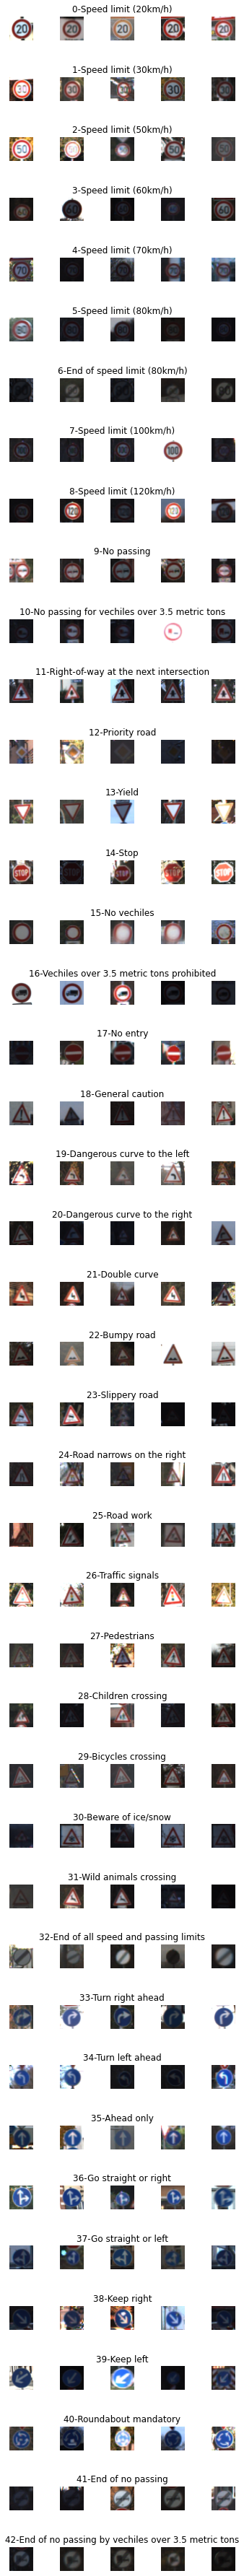

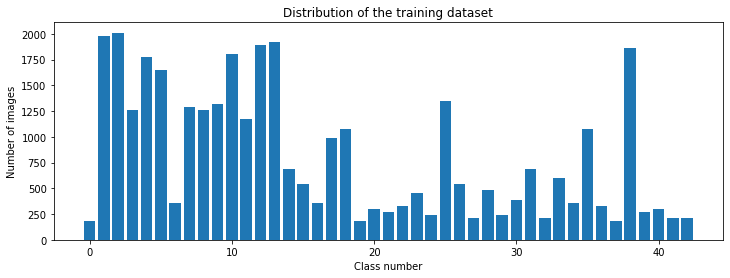

In [6]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

# Code snippets for later
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap = plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))


print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

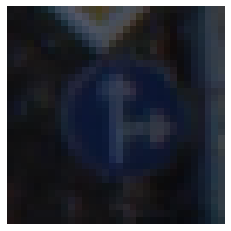

(32, 32, 3)


In [7]:
# Need to preprocess the data

import cv2

plt.imshow(X_train[1000])
plt.axis("off")
plt.show()

print(X_train[1000].shape)

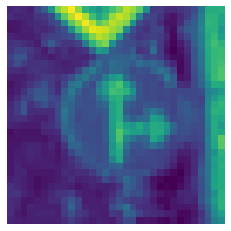

(32, 32)


In [8]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])

plt.imshow(img)
plt.axis("off")
plt.show()
print(img.shape)

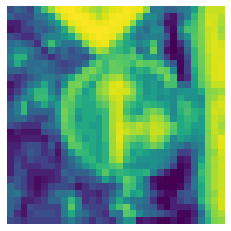

(32, 32)


In [9]:
# Histogram equalization aims to make the lightning in all images similar

def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)

plt.imshow(img)
plt.axis("off")
plt.show()
print(img.shape)

In [10]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255

  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

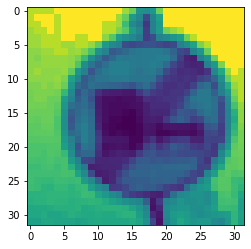

In [11]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])

In [12]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

(15, 32, 32, 1)


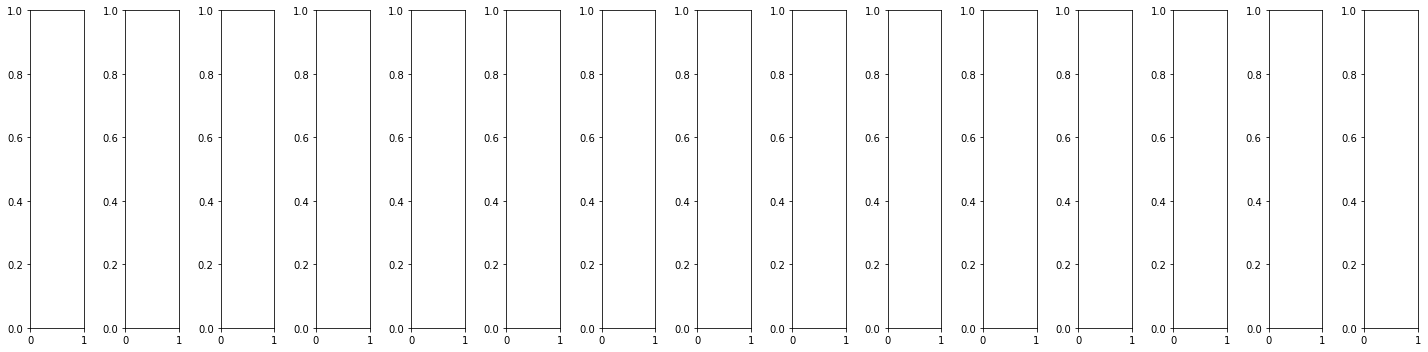

In [18]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)



fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
print(X_batch.shape)

In [19]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [20]:
# LeNet implementation

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

  return model




In [21]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

In [22]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)


Epoch 1/10
87/87 [==============================] - 11s 38ms/step - loss: 2.4590 - accuracy: 0.3400 - val_loss: 0.7328 - val_accuracy: 0.7918
Epoch 2/10
87/87 [==============================] - 2s 28ms/step - loss: 0.7055 - accuracy: 0.7799 - val_loss: 0.2891 - val_accuracy: 0.9143
Epoch 3/10
87/87 [==============================] - 2s 28ms/step - loss: 0.3999 - accuracy: 0.8752 - val_loss: 0.1818 - val_accuracy: 0.9492
Epoch 4/10
87/87 [==============================] - 2s 28ms/step - loss: 0.2885 - accuracy: 0.9097 - val_loss: 0.1362 - val_accuracy: 0.9592
Epoch 5/10
87/87 [==============================] - 2s 28ms/step - loss: 0.2321 - accuracy: 0.9257 - val_loss: 0.1117 - val_accuracy: 0.9683
Epoch 6/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1914 - accuracy: 0.9403 - val_loss: 0.0969 - val_accuracy: 0.9735
Epoch 7/10
87/87 [==============================] - 2s 28ms/step - loss: 0.1674 - accuracy: 0.9461 - val_loss: 0.0922 - val_accuracy: 0.9739
Epoch 8/10
8

Text(0.5, 0, 'Epoch')

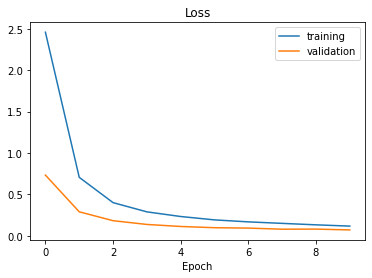

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

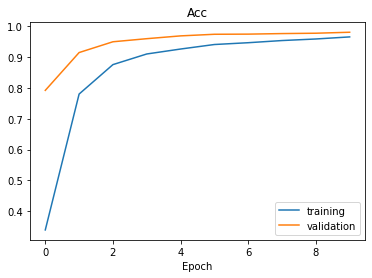

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acc')
plt.xlabel('Epoch')

In [25]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Test score:  0.13442079722881317
Test accuracy:  0.9644497036933899


(32, 32)
1/1 [==============================] - 0s 148ms/step
predicted sign: [31]


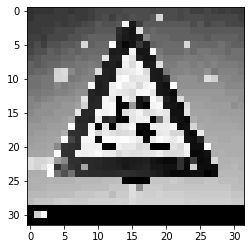

In [26]:
# Need to test

# URLS
# https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

# https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

# https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

# https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

# https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg

#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
predict_x=model.predict(img) 
prediction=np.argmax(predict_x,axis=1)

print("predicted sign: "+ str(prediction))

In [ ]:
# Fit generator, data augmentation!